## Загрузка библиотек

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


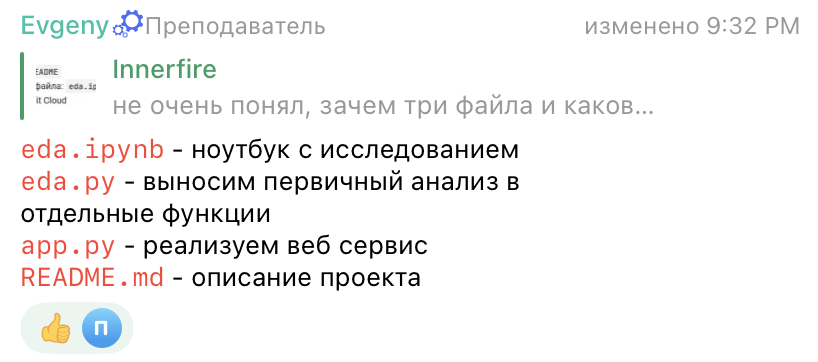

## Сборка датасета

In [18]:
# задам путь до файлов
path = 'datasets'

# path = '/Users/konstantin/Desktop/Машинное обучение и высоконагруженные системы/Интенсивы/Линейные модели и их презентация/Project/stepik_linear_models/datasets'

In [19]:
# задам датасеты
D_agreement = pd.read_csv(filepath_or_buffer = path + '/D_target' + '.csv')
D_clients = pd.read_csv(filepath_or_buffer = path + '/D_clients' + '.csv')
D_salary = pd.read_csv(filepath_or_buffer = path + '/D_salary' + '.csv') 

D_loan = pd.read_csv(filepath_or_buffer = path + '/D_loan' + '.csv') 
D_close_loan = pd.read_csv(filepath_or_buffer = path + '/D_close_loan' + '.csv')

D_work = pd.read_csv(filepath_or_buffer = path + '/D_work' + '.csv')
D_pens = pd.read_csv(filepath_or_buffer = path + '/D_pens' + '.csv') 
D_job = pd.read_csv(filepath_or_buffer = path + '/D_job' + '.csv')
D_last_credit = pd.read_csv(filepath_or_buffer = path + '/D_last_credit' + '.csv') 

In [20]:
# объединю в один датафрейм D_agreement (по 'ID_CLIENT') и D_clients (по 'ID')
new = pd.merge(D_agreement, D_clients, how = 'inner', left_on = 'ID_CLIENT', right_on = 'ID', indicator = True)
# объединю в один датафрейм new и D_salary - оба по 'ID_CLIENT'
new = pd.merge(new, D_salary, how = 'inner')
# оставлю в new только нужные признаки (ДО слияния с temp)
new = new[['ID_CLIENT', 'TARGET', 'AGE', 'GENDER', 
           'SOCSTATUS_WORK_FL', 'SOCSTATUS_PENS_FL', 'CHILD_TOTAL', 'DEPENDANTS', 'PERSONAL_INCOME']].copy(deep = True)


# объединю в один датафрейм D_close_loan и D_loan - оба по 'ID_LOAN'
temp = pd.merge(D_close_loan, D_loan)
# сделаю группировку по ID_CLIENT, не забуду посчитать правильные метрики ('ID_LOAN': 'count', 'CLOSED_FL': 'sum')
temp = temp.groupby(by = ['ID_CLIENT']).agg({'ID_LOAN': 'count', 'CLOSED_FL': 'sum'}).reset_index()
# переназову признаки, как указано в задании
temp = temp.rename(columns = {'ID_LOAN': 'LOAN_NUM_TOTAL', 'CLOSED_FL': 'LOAN_NUM_CLOSED'})


# объединю в один датафрейм new и temp - оба по 'ID_CLIENT'
new = pd.merge(new, temp, how = 'inner')


# удалю дубликаты и выровняю индексы
new = new.drop_duplicates().reset_index(drop = True)
df = new.drop(['ID_CLIENT'], axis = 1)


# добавлю долю погашенных кредитов 
df['LOAN_CLOSED_SHARE'] = df['LOAN_NUM_CLOSED']/df['LOAN_NUM_TOTAL']
df.head(2)

# https://pandas.pydata.org/docs/dev/reference/api/pandas.core.groupby.DataFrameGroupBy.agg.html
# https://www.geeksforgeeks.org/how-to-rename-columns-in-pandas-dataframe/
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html

,TARGET,AGE,GENDER,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,CHILD_TOTAL,DEPENDANTS,PERSONAL_INCOME,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_CLOSED_SHARE
0,0,49,1,1,0,2,1,5000.0,1,1,1.0
1,0,32,1,1,0,3,3,12000.0,1,1,1.0


In [21]:
# сохраню датасет на диск
df.to_csv('df.csv', index = False)

# https://www.geeksforgeeks.org/saving-a-pandas-dataframe-as-a-csv/

In [22]:
# проверю, что все работает
df = pd.read_csv('df.csv')
df.head(2)

,TARGET,AGE,GENDER,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,CHILD_TOTAL,DEPENDANTS,PERSONAL_INCOME,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_CLOSED_SHARE
0,0,49,1,1,0,2,1,5000.0,1,1,1.0
1,0,32,1,1,0,3,3,12000.0,1,1,1.0


#### **Функция на создание датасета** 

In [23]:
def create_dataset(path = 'datasets'):
    
    # задам датасеты
    D_agreement = pd.read_csv(filepath_or_buffer = path + '/D_target' + '.csv')
    D_clients = pd.read_csv(filepath_or_buffer = path + '/D_clients' + '.csv')
    D_salary = pd.read_csv(filepath_or_buffer = path + '/D_salary' + '.csv') 
    
    D_loan = pd.read_csv(filepath_or_buffer = path + '/D_loan' + '.csv') 
    D_close_loan = pd.read_csv(filepath_or_buffer = path + '/D_close_loan' + '.csv')
    
    D_work = pd.read_csv(filepath_or_buffer = path + '/D_work' + '.csv')
    D_pens = pd.read_csv(filepath_or_buffer = path + '/D_pens' + '.csv') 
    D_job = pd.read_csv(filepath_or_buffer = path + '/D_job' + '.csv')
    D_last_credit = pd.read_csv(filepath_or_buffer = path + '/D_last_credit' + '.csv')
    
    # объединю в один датафрейм D_agreement (по 'ID_CLIENT') и D_clients (по 'ID')
    new = pd.merge(D_agreement, D_clients, how = 'inner', left_on = 'ID_CLIENT', right_on = 'ID', indicator = True)
    
    # объединю в один датафрейм new и D_salary - оба по 'ID_CLIENT'
    new = pd.merge(new, D_salary, how = 'inner')
    
    # оставлю в new только нужные признаки (ДО слияния с temp)
    new = new[['ID_CLIENT', 'TARGET', 'AGE', 'GENDER', 
           'SOCSTATUS_WORK_FL', 'SOCSTATUS_PENS_FL', 'CHILD_TOTAL', 'DEPENDANTS', 'PERSONAL_INCOME']].copy(deep = True)

    # объединю в один датафрейм D_close_loan и D_loan - оба по 'ID_LOAN'
    temp = pd.merge(D_close_loan, D_loan)
    
    # сделаю группировку по ID_CLIENT, не забуду посчитать правильные метрики ('ID_LOAN': 'count', 'CLOSED_FL': 'sum')
    temp = temp.groupby(by = ['ID_CLIENT']).agg({'ID_LOAN': 'count', 'CLOSED_FL': 'sum'}).reset_index()
    
    # переназову признаки, как указано в задании
    temp = temp.rename(columns = {'ID_LOAN': 'LOAN_NUM_TOTAL', 'CLOSED_FL': 'LOAN_NUM_CLOSED'})
    
    # объединю в один датафрейм new и temp - оба по 'ID_CLIENT'
    new = pd.merge(new, temp, how = 'inner')
    
    # удалю дубликаты и выровняю индексы
    new = new.drop_duplicates().reset_index(drop = True)
    df = new.drop(['ID_CLIENT'], axis = 1)
    
    # добавлю долю погашенных кредитов 
    df['LOAN_CLOSED_SHARE'] = df['LOAN_NUM_CLOSED']/df['LOAN_NUM_TOTAL']
    
    return df

#### Функция сохранения датасета

In [24]:
def save_dataset(path = 'datasets'):
    df = create_dataset()
    df.to_csv(path_or_buf = path + '/df.csv', index = False)
    
    return df

#### **Функция загрузки датасета**

In [25]:
def open_dataset(path = 'datasets/df.csv'):
    """ reads df from given path """
    df = pd.read_csv(path)

    return df

In [26]:
save_dataset()
df = open_dataset()
df.head()

,TARGET,AGE,GENDER,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,CHILD_TOTAL,DEPENDANTS,PERSONAL_INCOME,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_CLOSED_SHARE
0,0,49,1,1,0,2,1,5000.0,1,1,1.0
1,0,32,1,1,0,3,3,12000.0,1,1,1.0
2,0,52,1,1,0,4,0,9000.0,2,1,0.5
3,0,39,1,1,0,1,1,25000.0,1,1,1.0
4,0,30,0,1,0,0,0,12000.0,2,1,0.5


### 
- вычислены числовые характеристики распределения числовых столбцов (среднее, min, max, медиана и так далее)
- вычислены числовые характеристики категориальных столбцов

In [14]:
# перекодирую признаки
df[['GENDER', 'SOCSTATUS_WORK_FL', 'SOCSTATUS_PENS_FL']] = df[['GENDER', 'SOCSTATUS_WORK_FL', 'SOCSTATUS_PENS_FL']].astype('category')
df.dtypes

TARGET                  int64
AGE                     int64
GENDER               category
SOCSTATUS_WORK_FL    category
SOCSTATUS_PENS_FL    category
CHILD_TOTAL             int64
DEPENDANTS              int64
PERSONAL_INCOME       float64
LOAN_NUM_TOTAL          int64
LOAN_NUM_CLOSED         int64
LOAN_CLOSED_SHARE     float64
dtype: object

In [15]:
# посмотрю на основные показатели количественных признаков
df.describe()

,TARGET,AGE,CHILD_TOTAL,DEPENDANTS,PERSONAL_INCOME,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_CLOSED_SHARE
count,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000
mean,0.119030,40.406096,1.099389,0.645208,13853.836323,1.387769,0.751889,0.440000
std,0.323835,11.601068,0.995411,0.812252,9015.467617,0.793566,0.988499,0.469487
min,0.000000,21.000000,0.000000,0.000000,24.000000,1.000000,0.000000,0.000000
25%,0.000000,30.000000,0.000000,0.000000,8000.000000,1.000000,0.000000,0.000000
50%,0.000000,39.000000,1.000000,0.000000,12000.000000,1.000000,0.000000,0.000000
75%,0.000000,50.000000,2.000000,1.000000,17000.000000,2.000000,1.000000,1.000000
max,1.000000,67.000000,10.000000,7.000000,250000.000000,11.000000,11.000000,1.000000


In [7]:
# посмотрю на основные показатели категориальных признаков
df.describe(include = 'category')

,GENDER,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL
count,15223,15223,15223
unique,2,2,2
top,1,1,0
freq,9964,13847,13176


#### Функции на вывод статистики

In [24]:
def stat_quant():
    '''main statistics on quantitative data'''
    # перекодирую признаки
    df[['GENDER', 'SOCSTATUS_WORK_FL', 'SOCSTATUS_PENS_FL']] = df[['GENDER', 'SOCSTATUS_WORK_FL', 'SOCSTATUS_PENS_FL']].astype('category')
    
    return df.describe()

In [29]:
def stat_cat():
    '''main statistics on categorical data'''
    # перекодирую признаки
    df[['GENDER', 'SOCSTATUS_WORK_FL', 'SOCSTATUS_PENS_FL']] = df[['GENDER', 'SOCSTATUS_WORK_FL', 'SOCSTATUS_PENS_FL']].astype('category')
    
    return df.describe(include = 'category')

In [30]:
stat_cat()

Статистика по категориальным данным


,GENDER,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL
count,15223,15223,15223
unique,2,2,2
top,1,1,0
freq,9964,13847,13176


### Отображено число пропусков, дубликатов в данных

In [123]:
# пропущенных значений нет
df.isna().sum()

TARGET               0
AGE                  0
GENDER               0
SOCSTATUS_WORK_FL    0
SOCSTATUS_PENS_FL    0
CHILD_TOTAL          0
DEPENDANTS           0
PERSONAL_INCOME      0
LOAN_NUM_TOTAL       0
LOAN_NUM_CLOSED      0
LOAN_CLOSED_SHARE    0
dtype: int64

In [124]:
def mis():
    '''missing analysis'''
    print(df.isna().sum())

In [125]:
mis()

TARGET               0
AGE                  0
GENDER               0
SOCSTATUS_WORK_FL    0
SOCSTATUS_PENS_FL    0
CHILD_TOTAL          0
DEPENDANTS           0
PERSONAL_INCOME      0
LOAN_NUM_TOTAL       0
LOAN_NUM_CLOSED      0
LOAN_CLOSED_SHARE    0
dtype: int64


**Комментарий студента:** дубликаты были удалены на этапе создания датасета

### Построена матрица корреляций

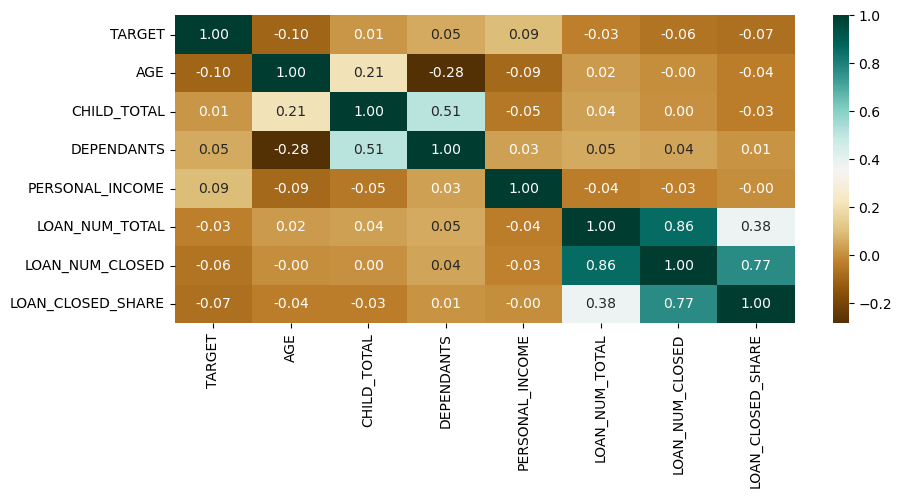

In [9]:
plt.figure(figsize = (10,4))
sns.heatmap(data = df.corr(), annot = True, fmt = '.2f', cmap = 'BrBG');

# https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html
# https://datastart.ru/blog/read/seaborn-heatmaps-13-sposobov-nastroit-vizualizaciyu-matricy-korrelyacii

#### Функция для корреляции

In [20]:
def correlation():
    '''Corraltion matrix on qualnitative data'''
    
    # обозначу категориальные признаки
    df[['GENDER', 'SOCSTATUS_WORK_FL', 'SOCSTATUS_PENS_FL']] = df[['GENDER', 'SOCSTATUS_WORK_FL', 'SOCSTATUS_PENS_FL']].astype('category')
    # график
    plt.figure(figsize = (10,4))
    sns.heatmap(data = df.corr(), annot = True, fmt = '.2f', cmap = 'BrBG');   

### Построены графики распределений числовых признаков (не менее, чем по двум признакам)

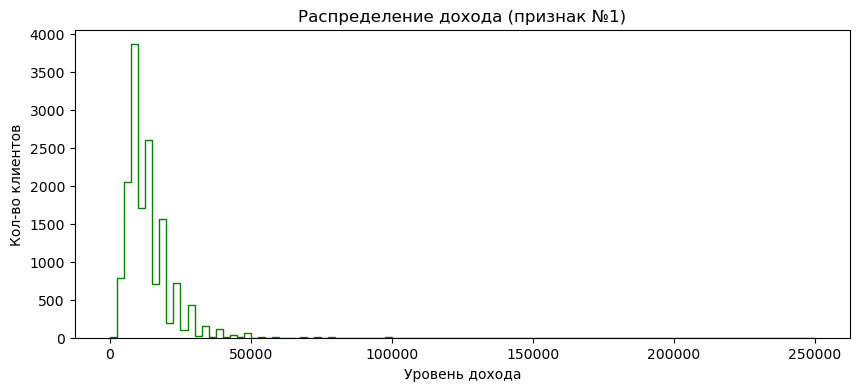

In [10]:
plt.figure(figsize = (10,4))
plt.hist(df['PERSONAL_INCOME'], bins = 100, histtype = 'step', color = 'green')
plt.xlabel('Уровень дохода')
plt.ylabel('Кол-во клиентов')
plt.title('Распределение дохода (признак №1)');

# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html

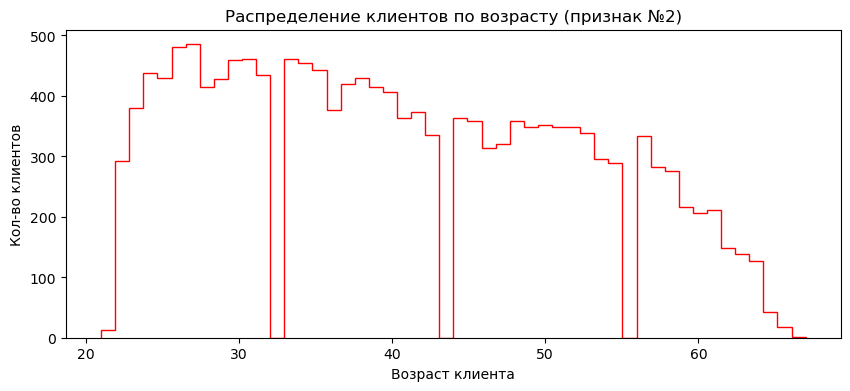

In [11]:
plt.figure(figsize = (10,4))
plt.hist(df['AGE'], bins = 50, histtype = 'step', color = 'red')
plt.xlabel('Возраст клиента')
plt.ylabel('Кол-во клиентов')
plt.title('Распределение клиентов по возрасту (признак №2)');

# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html

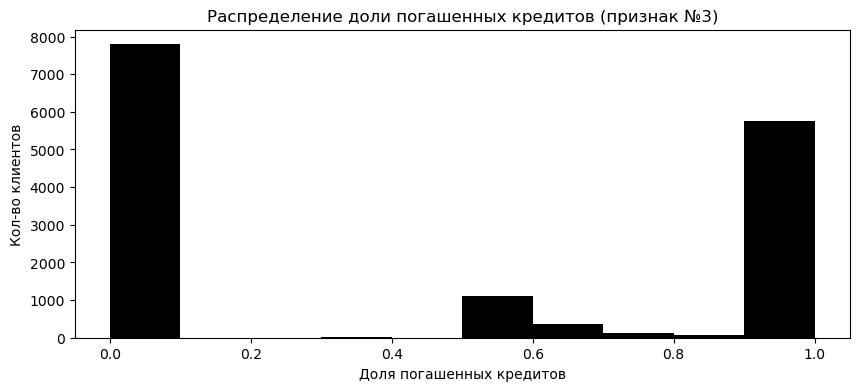

In [12]:
plt.figure(figsize = (10,4))
plt.hist(df['LOAN_CLOSED_SHARE'], bins = 10, histtype = 'bar', color = 'black')
plt.xlabel('Доля погашенных кредитов')
plt.ylabel('Кол-во клиентов')
plt.title('Распределение доли погашенных кредитов (признак №3)');

# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html

#### Функции для графиков

In [27]:
def graphs_quant():
        
    '''Income distribution'''
    plt.figure(figsize = (10,4))
    plt.hist(df['PERSONAL_INCOME'], bins = 100, histtype = 'step', color = 'green')
    plt.xlabel('Уровень дохода')
    plt.ylabel('Кол-во клиентов')
    plt.title('Распределение дохода (признак №1)');
    
    '''Age distribution'''
    plt.figure(figsize = (10,4))
    plt.hist(df['AGE'], bins = 50, histtype = 'step', color = 'red')
    plt.xlabel('Возраст клиента')
    plt.ylabel('Кол-во клиентов')
    plt.title('Распределение клиентов по возрасту (признак №2)');

    '''Closed loans share distribution'''
    plt.figure(figsize = (10,4))
    plt.hist(df['LOAN_CLOSED_SHARE'], bins = 10, histtype = 'bar', color = 'black')
    plt.xlabel('Доля погашенных кредитов')
    plt.ylabel('Кол-во клиентов')
    plt.title('Распределение доли погашенных кредитов (признак №3)');   
    

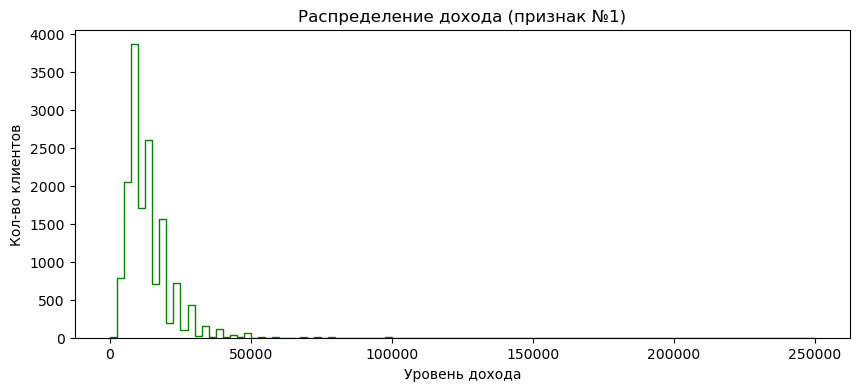

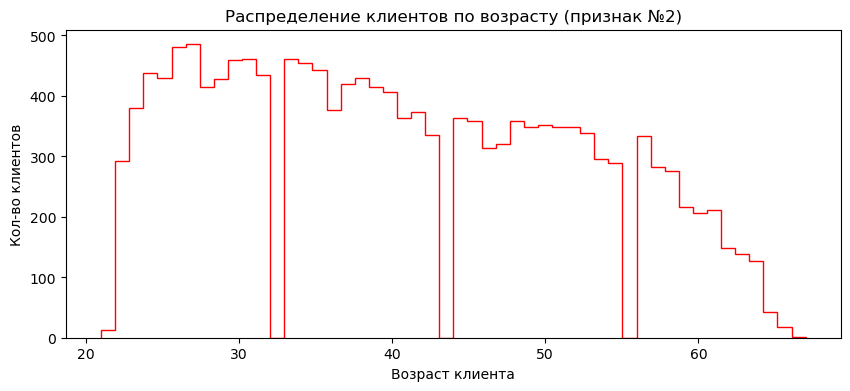

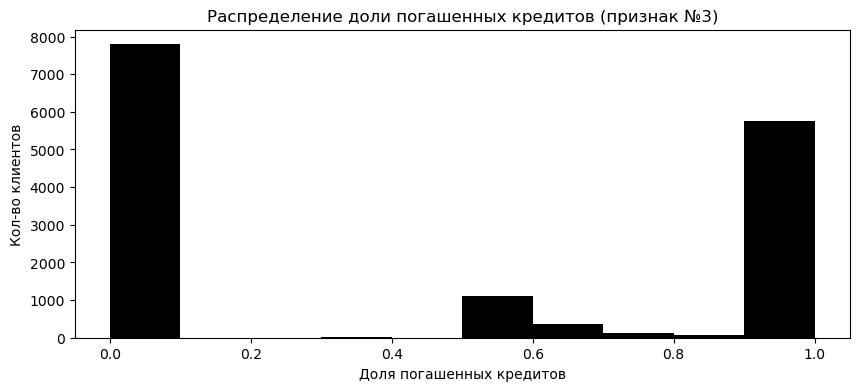

In [28]:
graphs_quant()

### построены графиков зависимостей целевой переменной и признаков (не менее, чем два графика)

#### Target & AGE

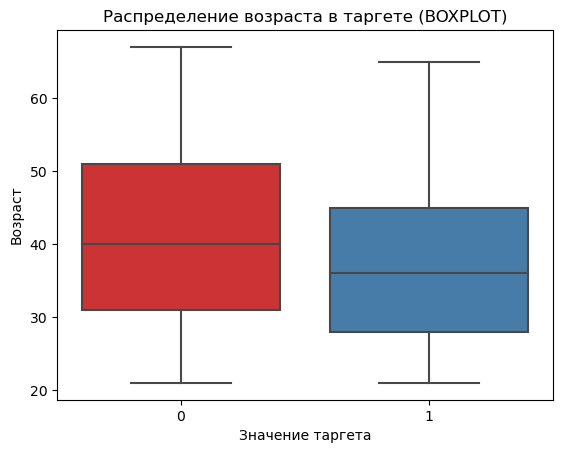

In [33]:
sns.boxplot(data = df, y = 'AGE', x = 'TARGET', palette = 'Set1');
plt.title('Зависимость возраста от таргета (BOXPLOT)')
plt.xlabel('Значение таргета')
plt.ylabel('Возраст');

# https://www.geeksforgeeks.org/boxplot-using-seaborn-in-python/

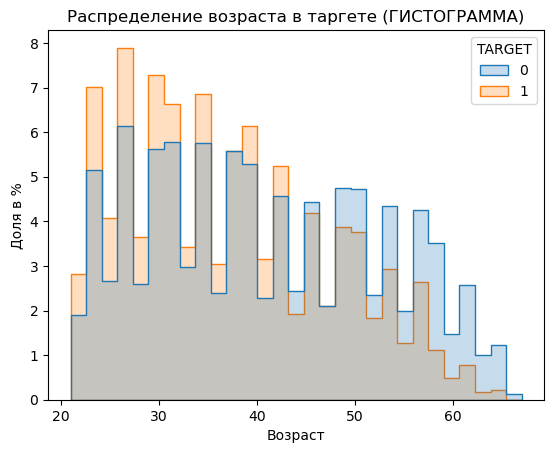

In [32]:
sns.histplot(data = df, x = 'AGE',  hue = 'TARGET', stat = 'percent', element = 'step', common_norm = False);
plt.title('Зависимость возраста от таргета (ГИСТОГРАММА)')
plt.xlabel('Возраст')
plt.ylabel('Доля в %');

# https://seaborn.pydata.org/generated/seaborn.histplot.html

####  Target & PERSONAL_INCOME

Text(0, 0.5, 'Логарифм дохода')

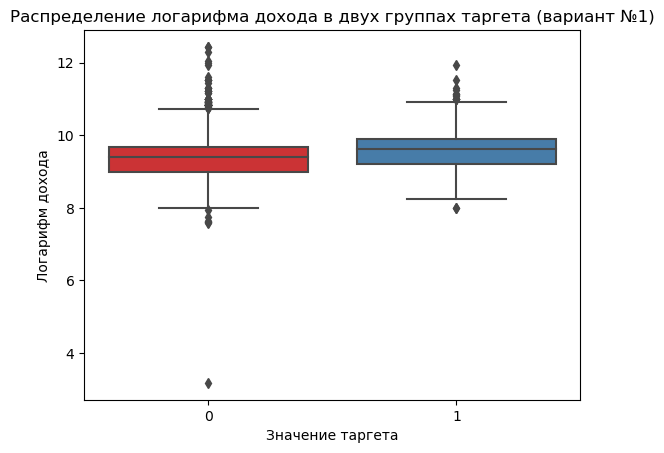

In [15]:
sns.boxplot(data = df, y = np.log(df['PERSONAL_INCOME']), x = 'TARGET', palette = 'Set1');
plt.title('Зависимость логарифма дохода от таргета(BOXPLOT)')
plt.xlabel('Значение таргета')
plt.ylabel('Логарифм дохода')

# https://www.geeksforgeeks.org/boxplot-using-seaborn-in-python/

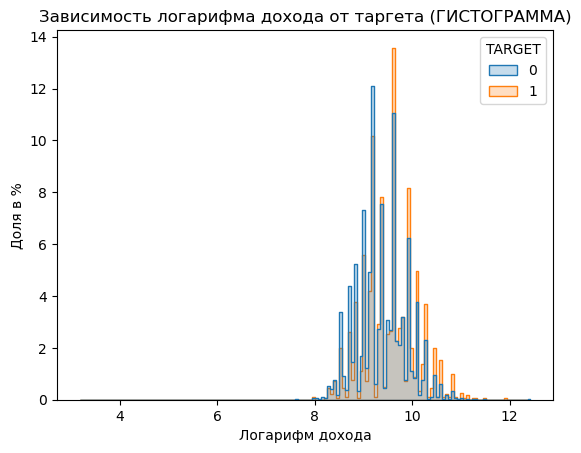

In [34]:
sns.histplot(data = df, x = np.log(df['PERSONAL_INCOME']),  hue = 'TARGET', stat = 'percent', element = 'step', common_norm = False);
plt.title('Зависимость логарифма дохода от таргета (ГИСТОГРАММА)')
plt.xlabel('Логарифм дохода')
plt.ylabel('Доля в %');

####  Target & LOAN_CLOSED_SHARE

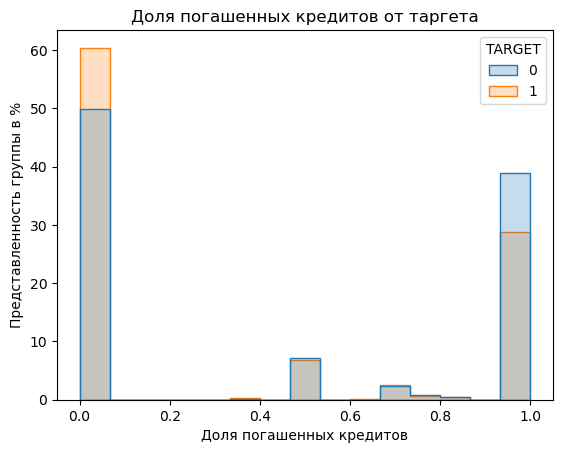

In [35]:
sns.histplot(data = df, x = 'LOAN_CLOSED_SHARE', hue = 'TARGET', stat = 'percent', element = 'step',
             common_norm = False)
plt.title('Доля погашенных кредитов от таргета')
plt.xlabel('Доля погашенных кредитов')
plt.ylabel('Представленность группы в %');

#### Target & LOAN_NUM_TOTAL

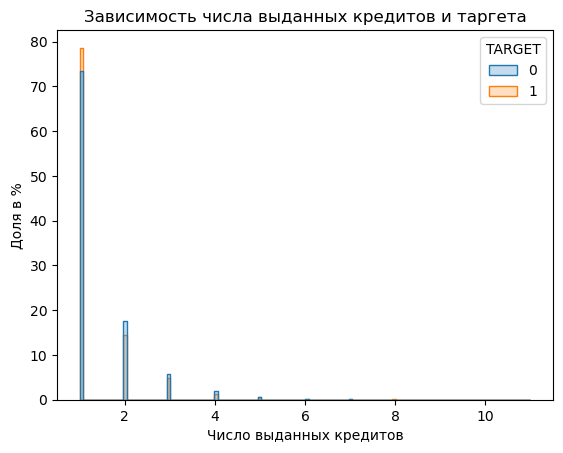

In [18]:
sns.histplot(data = df, x = 'LOAN_NUM_TOTAL', hue = 'TARGET', stat = 'percent', element = 'step',
             common_norm = False)
plt.title('Зависимость числа выданных кредитов и таргета')
plt.xlabel('Число выданных кредитов')
plt.ylabel('Доля в %');

**ЗАМЕТКИ НА ПОЛЯХ** -> Кредит чаще выдают клиентам:
- в возрасте до 40 лет
- с доходом на треть выше медианы
- у кого только 1 кредит


#### Функции для графиков

In [118]:
def graphs_causality():
    '''2 types of graphs (boxplot and histogram) on 3 dependencies:
        target vs. age
        target vs. log of income
        target vs. share of closed loans (only histogram)
        target vs. number of dependants (only histogram)
        '''
    fig, axes = plt.subplots(3,2, figsize = (12,12))
    fig.subplots_adjust(hspace = 0.33)
    
    # 1. target vs. age 
    sns.boxplot(data = df, y = 'AGE', x = 'TARGET', palette = 'Set1', ax = axes[0,0])
    axes[0,0].set_title('1. Зависимость возраста от таргета (BOXPLOT)', fontsize = 11)
    axes[0,0].set_xlabel('Таргет', fontsize = 10)
    axes[0,0].set_ylabel('Возраст', fontsize = 10)
    
    sns.histplot(data = df, x = 'AGE',  hue = 'TARGET', stat = 'percent', element = 'step', common_norm = False, ax = axes[0,1])
    axes[0,1].set_title('2. Зависимость возраста от таргета (ГИСТОГРАММА)', fontsize = 11)
    axes[0,1].set_xlabel('Возраст', fontsize = 10)
    axes[0,1].set_ylabel('Доля в %', fontsize = 10)
    
    # 2. target vs. log of income
    sns.boxplot(data = df, y = np.log(df['PERSONAL_INCOME']), x = 'TARGET', palette = 'Set1', ax = axes[1,0])
    axes[1,0].set_title('3. Логарифм дохода от таргета (BOXPLOT)', fontsize = 11)
    axes[1,0].set_xlabel('Таргет', fontsize = 10)
    axes[1,0].set_ylabel('Логарифм дохода', fontsize = 10)
    
    sns.histplot(data = df, x = np.log(df['PERSONAL_INCOME']),  hue = 'TARGET', stat = 'percent', element = 'step', common_norm = False, ax = axes[1,1]);
    axes[1,1].set_title('4. Логарифм дохода от таргета (ГИСТОГРАММА)', fontsize = 11)
    axes[1,1].set_xlabel('Логарифм дохода', fontsize = 10)
    axes[1,1].set_ylabel('Доля в %', fontsize = 10)
    axes[1,1].set_xlim(7.5,11.5)
    
    # 3. target vs. share of closed loans
    sns.histplot(data = df, x = 'LOAN_CLOSED_SHARE', hue = 'TARGET', stat = 'percent', element = 'step',
                 common_norm = False, ax = axes[2,0])
    axes[2,0].set_title('5. Доля погашенных кредитов от таргета', fontsize = 11)
    axes[2,0].set_xlabel('Доля погашенных кредитов', fontsize = 10)
    axes[2,0].set_ylabel('Доля в таргете, %', fontsize = 10)
    
    # 4. target vs. number of dependants
    sns.histplot(data = df, x = 'DEPENDANTS', hue = 'TARGET', stat = 'percent', element = 'step', binwidth = 0.5,
                 common_norm = False, ax = axes[2,1])
    axes[2,1].set_title('6. Зависимость числа Dependants и таргета', fontsize = 11)
    axes[2,1].set_xlabel('Число Dependants', fontsize = 10)
    axes[2,1].set_ylabel('Доля в таргете, %', fontsize = 10);

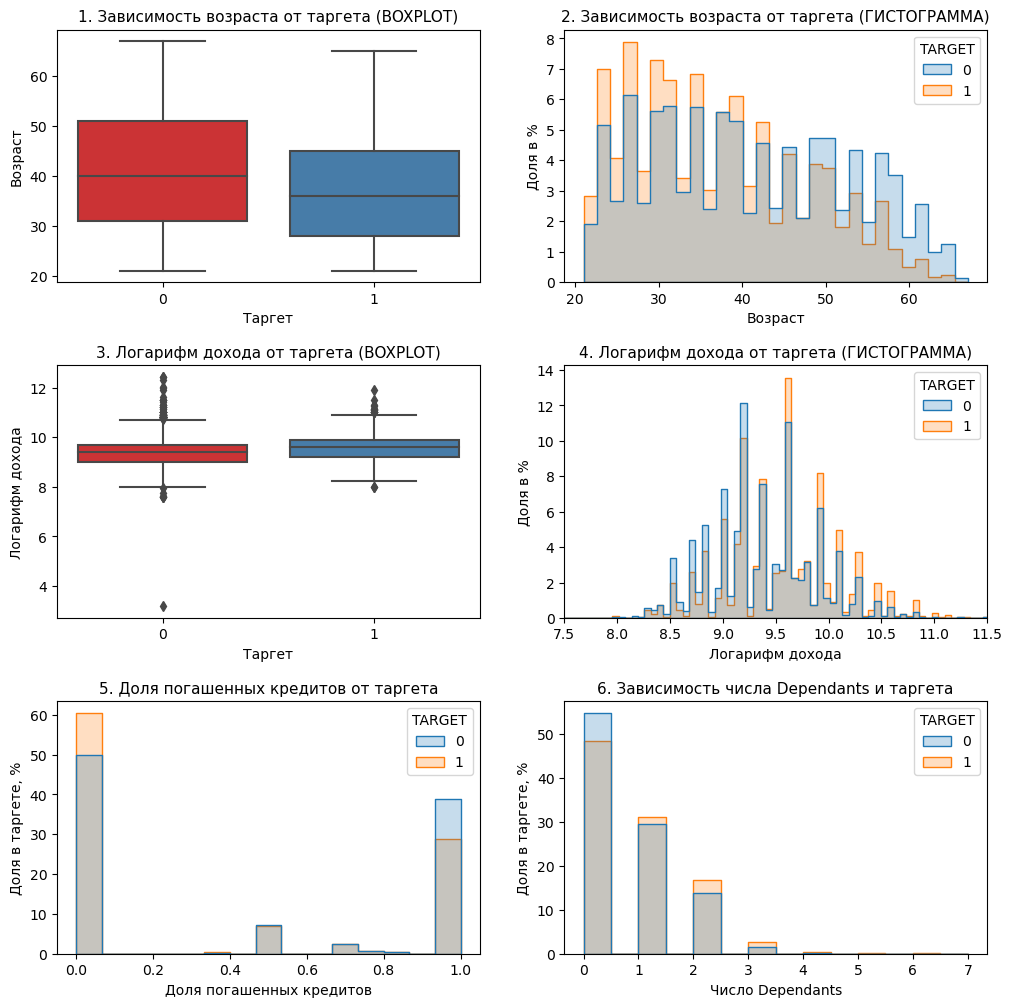

In [119]:
graphs_causality()

### Cделаны дополнительные исследования

#### Добавлены некоторые новые признаки
- удалю 'выбросы' дохода (все, что выше 40,001)
- дихотомизирую признак с возрастом  
- дихотомизирую признак с доходом  
- добавлю 2 новых признака:
    - размер домохозяйства
    - средний доход на 1 члена семьи
- перемножу доход и возраст

In [45]:
# создам экспериментальный датасет и удалю "выбросы" по доходу
df_cropped = df.copy()
df_cropped = df_cropped[df_cropped['PERSONAL_INCOME'] < 40001]

In [46]:
# перекодировка возраста (1-й способ)
df_cropped['AGE_recoded'] = df_cropped['AGE']
df_cropped['AGE_recoded'].mask(df_cropped['AGE_recoded'] < 40, 0, inplace = True)
df_cropped['AGE_recoded'].mask(df_cropped['AGE_recoded'] > 39, 1, inplace = True)

In [47]:
# перекодировка возраста (2-й способ)
# df_cropped['AGE_recoded'] = df_cropped['AGE'].replace(np.arange(41), [0]*41)
# df_cropped['AGE_recoded'] = df_cropped['AGE_recoded'].replace(np.arange(41, 70), [1]*len(np.arange(41, 70)))

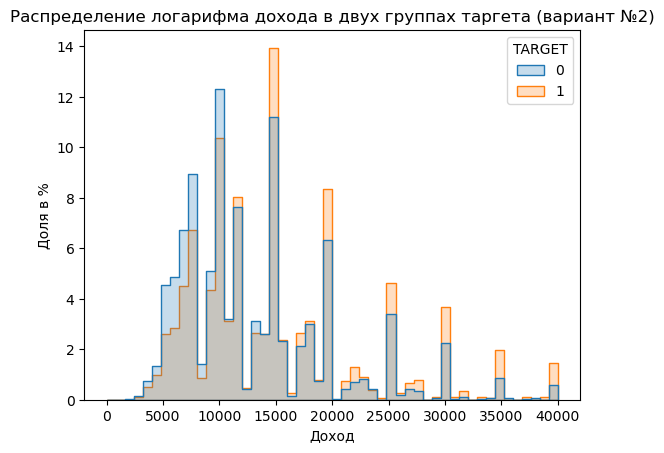

In [48]:
# ищу границу дохода для последующей перекодровки 
sns.histplot(data = df_cropped, x = 'PERSONAL_INCOME',  hue = 'TARGET', stat = 'percent', 
             element = 'step', common_norm = False, bins = 50);
plt.title('Распределение логарифма дохода в двух группах таргета (вариант №2)')
plt.xlabel('Доход')
plt.ylabel('Доля в %');

In [49]:
# непосредственно перекодировка дохода 
df_cropped['PERSONAL_INCOME_recoded'] = df_cropped['PERSONAL_INCOME']
df_cropped['PERSONAL_INCOME_recoded'].mask(df_cropped['PERSONAL_INCOME_recoded'] < 14400, 0, inplace = True)
df_cropped['PERSONAL_INCOME_recoded'].mask(df_cropped['PERSONAL_INCOME_recoded'] > 14499, 1, inplace = True)

In [51]:
# новые признаки 
# -> размер домохозяйства
# -> доход на 1 члена семьи
df_cropped['FAMILY_SIZE'] = df_cropped['CHILD_TOTAL'] + 2
df_cropped['INCOME_PER_CAPITA'] = df_cropped['PERSONAL_INCOME']/df_cropped['FAMILY_SIZE']

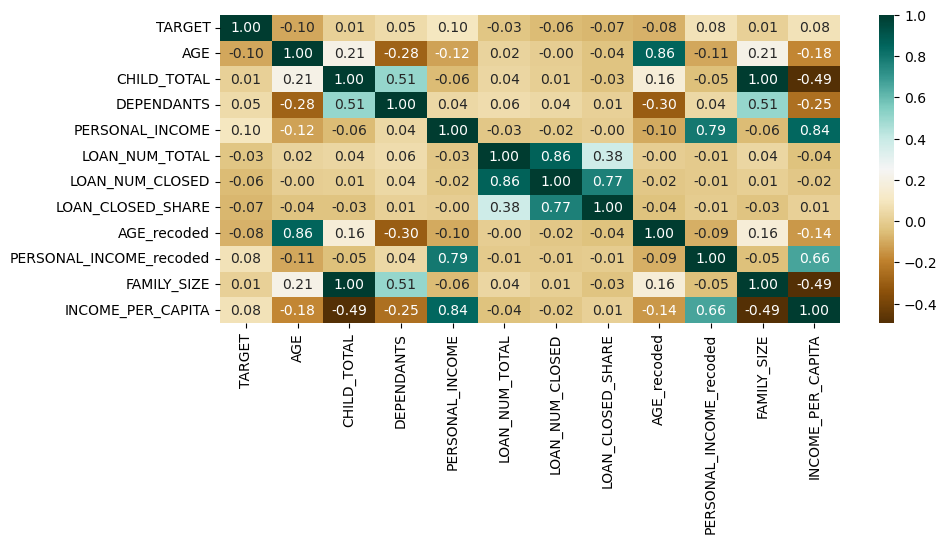

In [52]:
plt.figure(figsize = (10,4))
sns.heatmap(data = df_cropped.corr(), annot = True, fmt = '.2f', cmap = 'BrBG');

#### Сделаю кластерный анализ и попробую сегменты, которые чаще/ реже откликались на маркетинговые кампании

In [54]:
df.head(2)

,TARGET,AGE,GENDER,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,CHILD_TOTAL,DEPENDANTS,PERSONAL_INCOME,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_CLOSED_SHARE,clusters
0,0,49,1,1,0,2,1,5000.0,1,1,1.0,8
1,0,32,1,1,0,3,3,12000.0,1,1,1.0,0


In [11]:
%%time 

# задам скалер
scaler = StandardScaler()

# обучу scaler и стандартизую данные
scaler.fit(df.drop('TARGET', axis = 1))
scaled_data = scaler.transform(df.drop('TARGET', axis = 1))

# переведу данные из numpy в pandas
df_scaled = pd.DataFrame(scaled_data, columns = df.drop('TARGET', axis = 1).columns)

# проведу кластерный анализ
no_of_clusters = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
temp = {}

# проведу кластерный анализ несколько раз
for n_clusters in no_of_clusters:
    cluster = KMeans(n_clusters = n_clusters, random_state = 123)
    cluster.fit(df_scaled)
    cluster_labels = cluster.predict(df_scaled)

    # Silhouette -> качество кластеризации 
    silhouette_avg = silhouette_score(df_scaled, cluster_labels)
    temp[n_clusters] = silhouette_avg

# найду лучшее кластерное решение  
segments = list(temp.keys())
scores = list(temp.values())
best_segment = segments[scores.index(max(scores))]
print(f'Изучено {len(no_of_clusters)} кластерных решений, лучшее решение: \n Число кластеров = {best_segment}\n Silhouette ={max(scores): .3f}')

# сохраню модель-победитель
kmeans_best = KMeans(n_clusters=best_segment).fit(df_scaled)
# запишу принадлежность к кластеру в оригинальный датасет df
df['clusters'] = kmeans_best.predict(df_scaled)

Изучено 11 кластерных решений, лучшее решение: 
 Число кластеров = 9
 Silhouette = 0.259
CPU times: user 1min 2s, sys: 32.1 s, total: 1min 34s
Wall time: 20.2 s


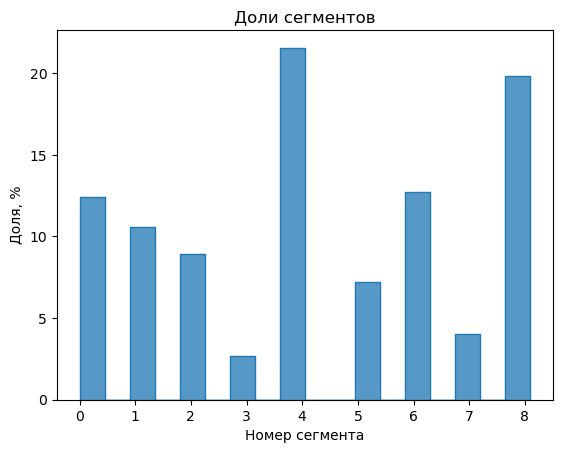

In [29]:
sns.histplot(data = df, x = 'clusters', stat = 'percent', element = 'step', binwidth = 0.45)
plt.title('Доли сегментов')
plt.xlabel('Номер сегмента')
plt.ylabel('Доля, %');

#### Функция для кластерного анализа

In [55]:
def cluster_analysis():
    '''KMeans cluster anaysis with standard scaler
    Returns dataset with new feature containing cluster number  
    '''
    # задам скалер
    scaler = StandardScaler()

    # обучу scaler и стандартизую данные
    scaler.fit(df.drop('TARGET', axis = 1))
    scaled_data = scaler.transform(df.drop('TARGET', axis = 1))

    # переведу данные из numpy в pandas
    df_scaled = pd.DataFrame(scaled_data, columns = df.drop('TARGET', axis = 1).columns)

    # проведу кластерный анализ
    no_of_clusters = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
    temp = {}

    # проведу кластерный анализ несколько раз
    for n_clusters in no_of_clusters:
        cluster = KMeans(n_clusters = n_clusters, random_state = 123)
        cluster.fit(df_scaled)
        cluster_labels = cluster.predict(df_scaled)

        # Silhouette -> качество кластеризации 
        silhouette_avg = silhouette_score(df_scaled, cluster_labels)
        temp[n_clusters] = silhouette_avg

    # найду лучшее кластерное решение  
    segments = list(temp.keys())
    scores = list(temp.values())
    best_segment = segments[scores.index(max(scores))]
    print(f'Изучено {len(no_of_clusters)} кластерных решений, лучшее решение: \n Число кластеров = {best_segment}\n Silhouette ={max(scores): .3f}')

    # сохраню модель-победитель
    kmeans_best = KMeans(n_clusters=best_segment).fit(df_scaled)
    # запишу принадлежность к кластеру в оригинальный датасет df
    df['clusters'] = kmeans_best.predict(df_scaled)    
    
    return df

#### Отрисую зависимость между принадлежностью к сегменту и откликом на маркетинговую акцию 

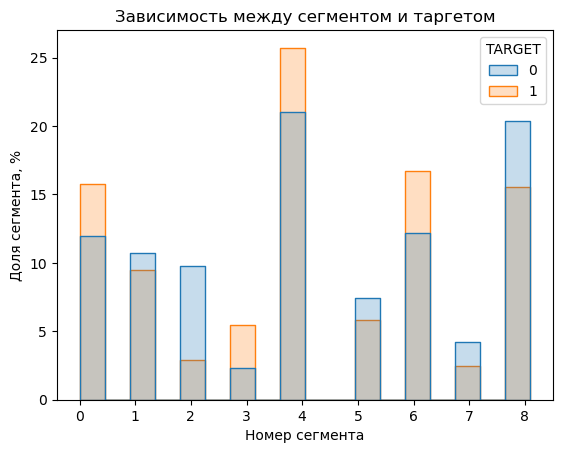

In [38]:
sns.histplot(data = df, x = 'clusters', hue = 'TARGET', stat = 'percent', element = 'step',
             common_norm = False, binwidth = 0.45)
plt.title('Зависимость между сегментом и таргетом')
plt.xlabel('Номер сегмента')
plt.ylabel('Доля сегмента, %');

**Комментарий студента:** на акцию хорошо откликаются представители сегментов 0,3,4,6, а сегменты 8 и особенно 2, наоборот, предпочитают не реагировать на предложения. 

In [53]:
# Сгруппирую основные показатели по сегментам (среднее)
grouped = df.groupby(by = 'clusters')[['AGE', 'CHILD_TOTAL', 'PERSONAL_INCOME', 'LOAN_NUM_TOTAL',
                                     'LOAN_CLOSED_SHARE']].agg('mean').round(2)
grouped

,AGE,CHILD_TOTAL,PERSONAL_INCOME,LOAN_NUM_TOTAL,LOAN_CLOSED_SHARE
clusters,,,,,
0,36.77,2.28,12846.17,1.13,0.29
1,36.85,0.81,16018.99,1.47,0.92
2,57.13,1.23,8033.81,1.27,0.39
3,38.72,0.92,46296.81,1.11,0.42
4,39.51,0.91,12319.03,1.02,0.00
5,39.38,1.18,13077.47,3.59,0.88
6,36.37,0.69,15550.30,1.02,0.00
7,57.14,1.25,15002.14,1.38,0.42
8,37.78,0.89,12197.02,1.43,0.91


#### Функция для отрисовки анализа по сегментам

In [78]:
def graph_clusters():
    '''Depicts connection between clusters and target'''
    
    # зависимость между сегментом и таргетом 
    graph = sns.histplot(data = df, x = 'clusters', hue = 'TARGET', stat = 'percent', element = 'step',
                 common_norm = False, binwidth = 0.45)
    plt.title('Зависимость между сегментами и таргетом')
    plt.xlabel('Номер сегмента')
    plt.ylabel('Доля сегмента, %');

#     return graph;


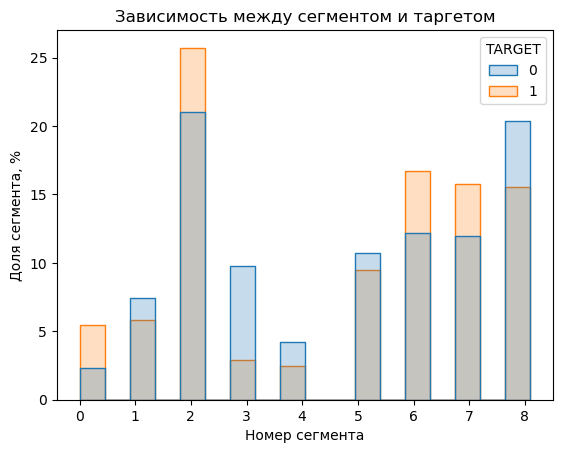

In [79]:
graph_clusters()

In [80]:
def profile_clusters():
    '''Makes segments' profile'''
    
    # профилирование кластеров 
    profile = df.groupby(by = 'clusters')[['AGE', 'CHILD_TOTAL', 'PERSONAL_INCOME', 'LOAN_NUM_TOTAL',
                                         'LOAN_CLOSED_SHARE']].agg('mean').round(2)
    return profile

In [81]:
profile_clusters()

,AGE,CHILD_TOTAL,PERSONAL_INCOME,LOAN_NUM_TOTAL,LOAN_CLOSED_SHARE
clusters,,,,,
0,38.72,0.92,46296.81,1.11,0.42
1,39.38,1.18,13077.47,3.59,0.88
2,39.51,0.91,12319.03,1.02,0.00
3,57.13,1.23,8033.81,1.27,0.39
4,57.14,1.25,15002.14,1.38,0.42
5,36.85,0.81,16018.99,1.47,0.92
6,36.37,0.69,15550.30,1.02,0.00
7,36.77,2.28,12846.17,1.13,0.29
8,37.78,0.89,12197.02,1.43,0.91


## Черновик


**Идентификатор - 'ID_CLIENT'** - 15,223
- AGREEMENT_RK — уникальный идентификатор объекта в выборке; **=D_agreement**
- TARGET — целевая переменная: отклик на маркетинговую кампанию (1 — отклик был зарегистрирован, 0 — отклика не было); **=D_agreement** 


**Идентификатор - 'ID'** - 16,000
- AGE — возраст клиента; **=D_clients**
- SOCSTATUS_WORK_FL — социальный статус клиента относительно работы (1 — работает, 0 — не работает); **=D_clients**
- SOCSTATUS_PENS_FL — социальный статус клиента относительно пенсии (1 — пенсионер, 0 — не пенсионер); **=D_clients**
- GENDER — пол клиента (1 — мужчина, 0 — женщина); **=D_clients**
- CHILD_TOTAL — количество детей клиента; **=D_clients**
- DEPENDANTS — количество иждивенцев клиента; **=D_clients**

**Идентификатор - 'ID_CLIENT'** - 15,223
- PERSONAL_INCOME — личный доход клиента (в рублях); **=D_salary**


- LOAN_NUM_TOTAL — количество ссуд клиента; **=D_loan**
- LOAN_NUM_CLOSED — количество погашенных ссуд клиента. **=D_close_loan**

In [137]:
new.dtypes

ID_CLIENT              int64
AGREEMENT_RK           int64
TARGET                 int64
AGE                    int64
GENDER                 int64
SOCSTATUS_WORK_FL      int64
SOCSTATUS_PENS_FL      int64
CHILD_TOTAL            int64
DEPENDANTS             int64
PERSONAL_INCOME      float64
LOAN_NUM_TOTAL         int64
LOAN_NUM_CLOSED        int64
dtype: object

In [138]:
new.describe()

,ID_CLIENT,AGREEMENT_RK,TARGET,AGE,GENDER,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,CHILD_TOTAL,DEPENDANTS,PERSONAL_INCOME,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED
count,1.522300e+04,1.522300e+04,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000
mean,1.068120e+08,6.540183e+07,0.119030,40.406096,0.654536,0.909610,0.134468,1.099389,0.645208,13853.836323,1.387769,0.751889
std,4.394646e+03,4.568181e+06,0.323835,11.601068,0.475535,0.286748,0.341165,0.995411,0.812252,9015.467617,0.793566,0.988499
min,1.068044e+08,5.991015e+07,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000,1.000000,0.000000
25%,1.068082e+08,6.192092e+07,0.000000,30.000000,0.000000,1.000000,0.000000,0.000000,0.000000,8000.000000,1.000000,0.000000
50%,1.068120e+08,6.437100e+07,0.000000,39.000000,1.000000,1.000000,0.000000,1.000000,0.000000,12000.000000,1.000000,0.000000
75%,1.068158e+08,6.708802e+07,0.000000,50.000000,1.000000,1.000000,0.000000,2.000000,1.000000,17000.000000,2.000000,1.000000
max,1.068196e+08,7.529224e+07,1.000000,67.000000,1.000000,1.000000,1.000000,10.000000,7.000000,250000.000000,11.000000,11.000000
